# Studio 7 -- The Fast Fourier Transform and LIGO Data Analysis
## Put your group number and the full names of you and your groupmates here:
### Group: #9
- 1 -- Hannah James
- 2 -- Viktorya Hunanyan
- 3 -- Victor Nguyen



Today, we will be analyzing the raw data from the first gravitational-wave signal observed by LIGO, GW150914.  This event, the merger of two black holes about 30 times the mass of the sun, won the Nobel Prize, and ushered in a new era of gravitational-wave astronomy.

This studio is largely based on the more complete analysis tutorial from LIGO itself (See the paper [here](https://arxiv.org/abs/1908.11170) and the associated GitHub respositroy [here](https://github.com/gwosc-tutorial/Data_Guide)).  We are ignoring some of the normalizations that are required to get the correct overall amplitude of the signal, but everything else is quantitatively correct.

In [234]:
## run this cell first to import all the necessary tools
import numpy as np
from matplotlib import pyplot as plt 
from scipy import fft, interpolate
from IPython.display import Audio
import h5py

# Problem 1

## Getting the data and Understanding LIGO's sensitivity

First things first, we'll need to load in the data from LIGO to perform the analysis.  There are a few different tools you can use here, but the most straightforward is just to use `np.loadtxt`.

The following command loads in 4 second of LIGO data at a sampling rate of 4096 Hz.  The variable `N` is the total number of samples in the data file

In [238]:
sample_rate = 4096 # Samples per second
length = 4 # Length of clip
N = sample_rate*length # Total number of samples

times,h_of_t = np.loadtxt("GW150914-H-H1.txt",unpack=True) ## Load the data

## Part A) Plot LIGO Data and Make an Audio File
Plot the initial signal (the raw output from the detector) as a function of time, using the samples we load in below

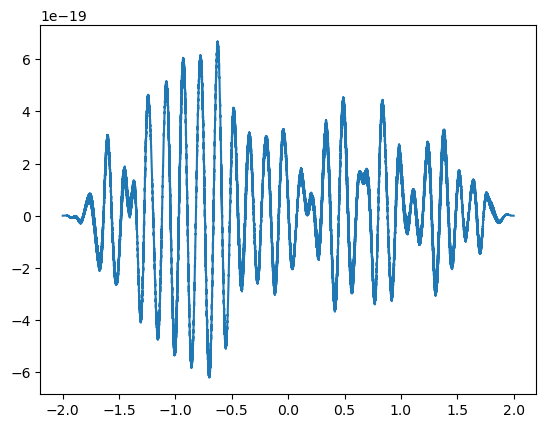

In [241]:
##Plot goes here 
plt.plot(times, h_of_t)
plt.show()

In [243]:
## You can also create an audio file of the data using the following command
Audio(h_of_t,rate=sample_rate)

## Part B) Understanding LIGO's sensitivity (read carefully)
 
LIGO is more sensitive to some frequencies than others.  We can quantify this statement by computing the **power spectral density (PSD)** of the detector noise at different frequencies.  In short, if I have some noise that I represent as $x(t)$ over some interval $T$, you can think of the PSD as a function that tells you how much power is in a signal $x$ at a frequency $f$ by taking the sign

$$
\text{PSD}(f) = \lim_{T\rightarrow \infty} \frac{1}{T} \left|\tilde{x}(f)\right|^2
$$

See [the Wikipedia page](https://en.wikipedia.org/wiki/Spectral_density) for more information.  However, the definition here is closely related to the FFT, and as such `Scipy` already contains methods for compusing the PSD.  

**TLDR** The smaller the PSD, the quieter the noise is at a given frequency, and the more sensitive LIGO is.

I've given you below code that loads in the PSD, creates an **interpolator** (funcion that will return values of the PSD at arbitrary frequencies), and plots them. **Based on this**, what frequencies is LIGO most sensitive to?

In [246]:
psd_freqs,psd_value = np.loadtxt("GW150914_PSD.txt",unpack=True)

psd = interpolate.interp1d(psd_freqs,psd_value)

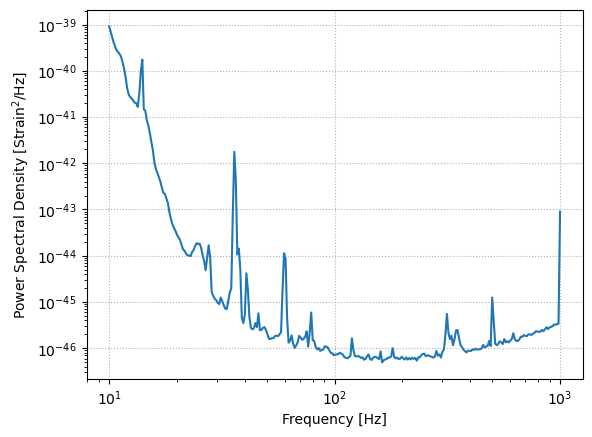

In [250]:
freq_samples = np.logspace(1,3,300)
psd_values = psd(freq_samples)

plt.plot(freq_samples,psd_values)
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Frequency [Hz]")
plt.ylabel(r"Power Spectral Density [$\rm{Strain}^2/{\rm{Hz}}$]")
plt.grid(True,ls=':')

**LIGO is most sensitive at a little over 100Hz.**

# Problem 2

## Cleaning the data

Because LIGO is more sensitive to some frequencies than others, any signal we measure will appear to have more power (be louder) at those sensitive frequencies.  But since we want to see the wave as it actually is in nature, we need to rescale the noise so that every frequency of noise contributes equally to the signal.  This process is called **whitening** the noise (i.e., turning it into white noise).

You can whiten the noise by dividing every sample in your `fft` by the square root of the PSD at that frequency, i.e.

$$
\tilde{x}_{\rm white}(f)=\frac{\tilde{x}(f)}{\sqrt{\rm{PSD}(f)}}
$$

Below, I'm computing the FFT of the LIGO signal.  The `rfft` is just like the regular `fft`, but it assumes the signal is real valued, which means that it only needs to keep the positive frequencies (since the negative frequencies will just be copies of the positive ones).

In [255]:
freqs = fft.rfftfreq(N,1/sample_rate)
x_tilde = fft.rfft(h_of_t)

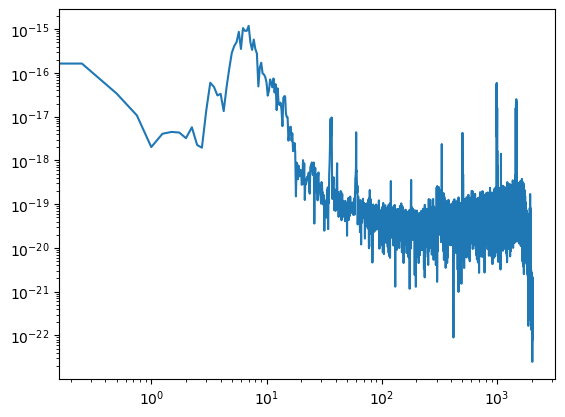

In [257]:
plt.plot(freqs,np.abs(x_tilde))
plt.xscale('log')
plt.yscale('log')

**Using the above definition**, whiten the LIGO signal using the PSD interpolator, and compute the inverse FFT (using `irfft`).  Plot the cleaned signal and create a new audio file

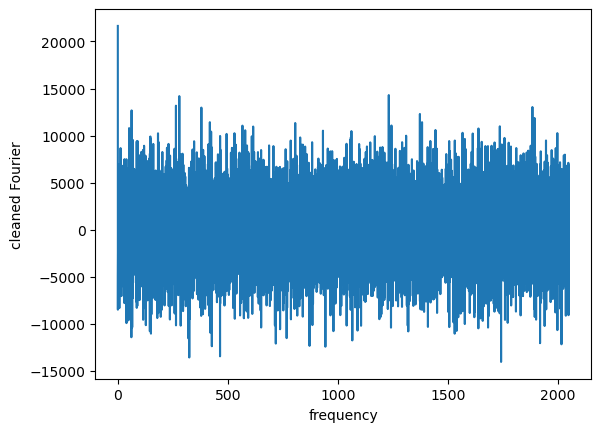

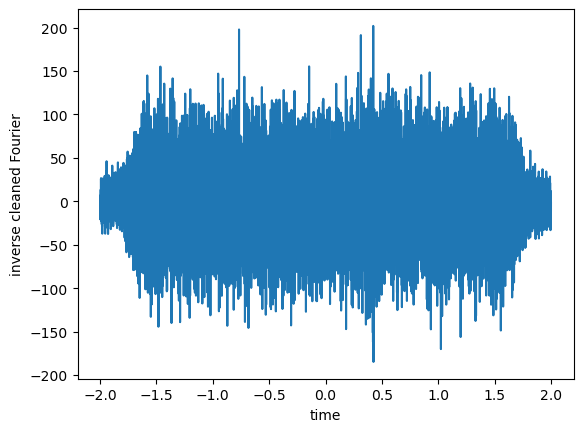

In [260]:
## Answer goes here

cleaned = psd(freqs)
whitened = x_tilde/np.sqrt(cleaned)

plt.plot(freqs, whitened)
plt.xlabel("frequency")
plt.ylabel("cleaned Fourier")
plt.show()

inverse = fft.irfft(whitened)
plt.plot(times, inverse)
plt.xlabel("time")
plt.ylabel("inverse cleaned Fourier")
plt.show()

In [262]:
## Audio goes here
Audio(inverse,rate=sample_rate)

# Problem 3

## Creating the Bandpass Filter and finding GW150914

Above, we can kind of hear a signal, but there's still a ton of noise.  To clean that up, we will implement. **bandpass filter** to remove frequencies below 35Hz and above 350Hz.

Using your whitened data from Problem2, the `rfft` and `irfft` functions, and the FFT example from Lecture 21 as a guide, **set all frequencies > 350Hz and < 35Hz to 0**.  Plot the results and create an audio file. Can you zoom in (using `plt.xlim`) to the exact time that the signal arrives?  How does it compare to Figure 1 of the [detection paper](https://arxiv.org/abs/1602.03837)?

In [266]:
## Bandpass goes here

whitened[(np.abs(freqs) > 350)] = 0 
whitened[(np.abs(freqs) < 35)] = 0
new = fft.irfft(whitened)

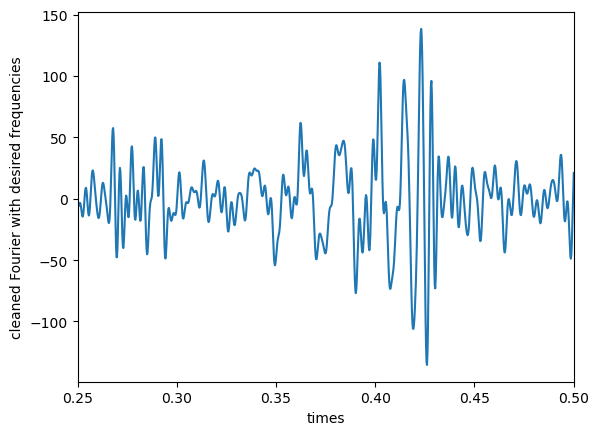

In [268]:
##Plot goes here
plt.plot(times, new)
plt.xlabel("times")
plt.xlim(0.25,0.5)
plt.ylabel("cleaned Fourier with desired frequencies")
plt.show()

In [270]:
## Audio goes here
Audio(new, rate=sample_rate)

In [274]:
#Yes, we can zoom in to see the exact time when signal arrives, which is when the wave spikes between 0.4 and 0.45 seconds.. 
#This compares to figure 1 in agreeance. The scales are different, but the peak where the signal is lines up rather well between 0.4 and 0.45
#seconds.